## **Classification of Rice From Images Using CNNs**
### ISC4311 Final Project | Rhea Nibert | December 4, 2025

### **Introduction to Notebook**

This is the notebook for the entire workflow on my course project. The goal of this project is to process images of rice grains and classify them into one of five types (Arborio, Basmati, Ipsala, Jasmine, or Karacadag) using supervised learning, specifically convolutional neural networks (CNNs). 

**IMPORTANT**:
- The code was developed with Python 3.11 to ensure support for TensorFlow. If you run into issues, try downgrading your Python environment version.
- The cells are meant to be run sequentially from top to bottom, so if rerunning code, be sure to use the "Run All Cells" option.
- I sampled just 5000 images from this folder for training my model, which your CPU should be able to handle, but you can try using a smaller `random.sample()` if you run into memory issues.

I began my workflow by importing all Python packages that I will use. If running the notebook for the first time, uncomment the first line to install the packages.

In [1]:
# !pip install tensorflow keras scikit-learn matplotlib pandas numpy pillow opencv_python kagglehub requests
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from cv2 import GaussianBlur
from pathlib import Path
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import kagglehub
import tempfile
import requests
import random
import shutil
import sys
import os

# Seed random generators
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### **Data Preprocessing**

The first step is loading in the dataset. I used the `kagglehub` library to do this. If you wish to delete the dataset after running this notebook, you can find it in your local storage at the `path` printed below.

In [2]:
# Download dataset
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

# Print path
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


Upon inspecting this folder in local storage, I discovered that the images for each rice type are stored in subfolders. I walked through the folders in the directory to locate the paths of these target folders.

In [3]:
# Define name of each rice type (folder names)
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Walk through the dataset directory and find these folders
folder_paths = []
for root, dirs, files in os.walk(path):
    for d in dirs:
        if d in rice_types:
            full_path = os.path.join(root, d)
            folder_paths.append(full_path)

# Print folder paths
print("Paths of folders containing images:")
for path in folder_paths:
    print(f"{path.split('/')[-1]}: {path}")

Paths of folders containing images:
Karacadag: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Karacadag
Ipsala: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Ipsala
Arborio: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Arborio
Basmati: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Basmati
Jasmine: /Users/rheanibert/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Jasmine


Each image needs to be processed so it works with CNNs. I defined the function below to process the images. I set the size to 224 because I found that this is the standard size for images in neural networks.

In [4]:
# Function to process images
def process_image(img_file, size=224):
    # Convert the color channels to RBG
    img = Image.open(img_file).convert("RGB")
    
    # Resize the image
    img = img.resize((size, size))
    
    # Normalize the color channels to 0-1
    img = np.array(img) / 255.0 
    
    return img

I looped through the image folders and rice type labels to form the NumPy arrays used for modeling. I sampled 1000 images of each rice type because there were originally 15000 each, which is too computationally expensive. I ran the `process_image` function on each image from the folders.

In [5]:
# Define lists to save images and class labels
images = []
labels = []

# Loop through each rice type and the folder path with its images
for rice_type, folder in zip(rice_types, folder_paths):
    # Convert the folder string to a path
    folder = Path(folder)

    # Get all images from the folder
    all_images = list(folder.glob("*"))

    # Sample 1000 images from the folder
    sampled_images = random.sample(all_images, 1000)

    # Loop through the image files
    for image_file in sampled_images: 
        # Process the image
        image = process_image(image_file)

        # Add images and labels to lists
        images.append(image)
        labels.append(rice_type)
             
    print(f"Loaded {rice_type} images") 

# Convert images and labels to NumPy arrays
images = np.array(images, dtype=np.float32)
labels = np.array(labels)

# Generate a random permutation of indices
idx = np.random.permutation(len(images))

# Shuffle both arrays using this index order
images = images[idx]
labels = labels[idx]

# Confirm number of images loaded
print(f"\nLoaded {len(images)} images total")

Loaded Arborio images
Loaded Basmati images
Loaded Ipsala images
Loaded Jasmine images
Loaded Karacadag images

Loaded 5000 images total


To ensure the images were processed correctly, I printed a random image of each rice type.

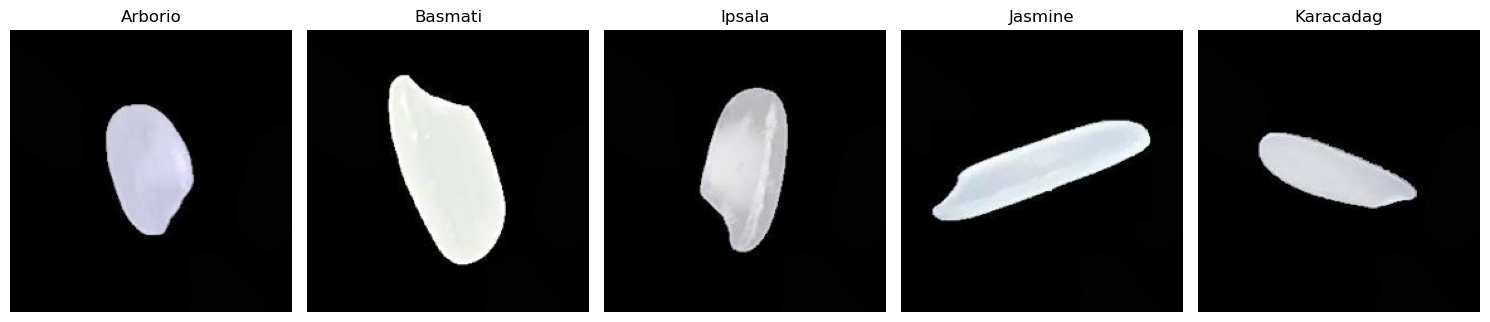

In [6]:
# Create a figure with subplots
fig, axes = plt.subplots(1, len(rice_types), figsize=(15, 5))

for i, label in enumerate(rice_types):
    # Find all indices for this specific label
    indices = np.where(labels == label)[0]
    
    # Pick one random index
    random_idx = np.random.choice(indices)
   
    # Get the corresponding image
    img = images[random_idx]
    
    # Display it in the subplot
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

The final step before modeling is to encode the string labels as numbers and perform a train/validation/test split.

In [7]:
# Encode labels as integers and ensure they are treated as categorical (one-hot encoding)
le = LabelEncoder()
labels_int = le.fit_transform(labels)
labels_one_hot = to_categorical(labels_int, num_classes=5)

# Split into Train (70%), Validation (15%), Test (15%)
# First split: 70% Train, 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_one_hot, test_size=0.3, random_state=0, 
    stratify=labels_int # Ensure class balance
)

# Second split: Split the 30% Temp into equal Validation and Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, 
    stratify=np.argmax(y_temp, axis=1) # Ensure class balance (reverse one-hot-encoding for this)
)

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (3500, 224, 224, 3)
Validation shape: (750, 224, 224, 3)
Testing shape: (750, 224, 224, 3)


### **Model Creation and Training**

I then proceeded to create my CNN model. I used a common deep learning structure for learning patterns from images:

1. **Input Layer**

    The model accepts images with a shape of 224×224×3 (RGB). This ensures all images entering the network have a consistent size.

2. **Convolution + Pooling Feature Extraction Blocks**

    The first part of the model consists of three convolutional blocks. Each block contains:

    * `Conv2D` layers to learn visual features
      (starting from simple edges → textures → complex shapes)
    * `BatchNormalization` to stabilize and speed up training
    * `MaxPooling2D` to reduce spatial dimensions and prevent overfitting

    As the blocks progress, the number of filters increases (32 → 64 → 128) to allow the network to learn richer patterns.

    A small `Dropout` layer is added after the final block to reduce overfitting.

3. **Dense Classification**

    After feature extraction, the data is flattened and passed into fully connected layers:

    * A `Dense` hidden layer learns relationships between the extracted features
    * `BatchNormalization` + `Dropout` help generalize and prevent the model from memorizing the data
    * A final `Dense` layer with softmax activation outputs probabilities across the 5 classes

In [8]:
def build_model():
    model = Sequential([
        # Input dimension later
        Input(shape=(224, 224, 3)),

        # Block 1: Capture basic features
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Block 2: Capture textures and patterns
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Block 3: Capture complex shapes
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25), 

        # Flattening and Dense Layers
        Flatten(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5), 

        # Output Layer
        Dense(5, activation="softmax")
    ])
    
    return model

# Build and summarize
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,013 (42.61 MB)

 Trainable params: 11,170,309 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

After defining the model, I compiled it using the Adam optimizer and categorical cross-entropy loss, which is appropriate for multi-class classification tasks with one-hot encoded labels. I also tracked accuracy during training to evaluate model performance.
To improve training efficiency and prevent overfitting, I set up two callbacks:
1. `EarlyStopping` monitors the validation loss and stops training if it doesn’t improve for 5 consecutive epochs, restoring the model weights from the epoch with the best performance. This prevents unnecessary training once the model has converged.
2. `ReduceLROnPlateau` also monitors the validation loss and reduces the learning rate by a factor of 0.1 if progress stalls for 3 epochs, allowing the model to fine-tune its learning and potentially escape small plateaus.
   
These callbacks ensure that training adapts dynamically, helping the model converge faster, maintain the best weights, and avoid wasting computation on redundant epochs.


In [9]:
# Compile
model.compile(
    optimizer="adam",                  # Adjusts learning rate dynamically
    loss="categorical_crossentropy",   # Multi-class classification with one-hot encoded labels
    metrics=["accuracy"]               # Evaluate based on accuracy of predictions
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",              # Watches validation loss
    patience=5,                      # Stop training if val loss doesn't improve after 5 epochs
    restore_best_weights=True,       # Restore model from the best epoch
    verbose=1                        # Print a message when early stopping happens
)

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",              # Watches validation loss
    factor=0.1,                      # Learning rate x 0.1
    patience=3,                      # Reduce learning rate if no improvement after 3 epochs
    min_lr=1e-6,                     # Ensure learning rate doesn't get too small
    verbose=1                        # Print when learning rate is reduced
)

Training the model takes a while, so I saved the output and trained model to avoid having to run the training process again to access the model information. In the below cell, I defined a class to write output to the console and a file when training the model.

In [10]:
class DoubleLog(object):
    def __init__(self, filename):
        self.file = open(filename, "w")
        self.stdout = sys.stdout

    def write(self, data):
        self.file.write(data)
        self.stdout.write(data)

    def flush(self):
        self.file.flush()
        self.stdout.flush()
        
    def close(self):
        self.file.close()
        sys.stdout = self.stdout 

I then trained the model and set up loggers to capture the training process and save the final model. Note that the code below simply loads in the pre-created files, but you can uncomment the training code to train the model in real time.

In [11]:
"""
# Save printed training logs and print to console
sys.stdout = DoubleLog("initial_training_console_output.txt")

# CSV logger saves per-epoch results
csv_logger = CSVLogger("initial_training_metrics.csv", append=False)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,                       # Max number of epochs
    batch_size=32,                   # Number of samples processed at a time
    validation_data=(X_val, y_val),  # Use validation data during training
    callbacks=[early_stopping, reduce_lr, csv_logger], # Add callbacks
    verbose=2
)

# Save the trained model weights
model.save_weights("initial_model.weights.h5")

# Close the logger
sys.stdout.close()
"""

# GitHub URLs containing trained model data
console_output_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/initial_training_console_output.txt"
metrics_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/initial_training_metrics.csv"
model_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/initial_model.weights.h5"

# Retrieve and print training output
response = requests.get(console_output_url)
console_text = response.text
print("Training Output")
print(console_text)

# Load training metrics for later use
metrics = pd.read_csv(metrics_url)

# Download the model weights file
local_file = "initial_model.weights.h5"
response = requests.get(model_url)
with open(local_file, "wb") as f:
    f.write(response.content)

# Build the model and load the weights
model = build_model()
model.load_weights(local_file)

# Delete the local weights file
os.remove(local_file)

Training Output
Epoch 1/30
110/110 - 39s - 351ms/step - accuracy: 0.8749 - loss: 0.3712 - val_accuracy: 0.2000 - val_loss: 3.1105 - learning_rate: 0.0010
Epoch 2/30
110/110 - 35s - 316ms/step - accuracy: 0.9594 - loss: 0.1189 - val_accuracy: 0.2000 - val_loss: 4.7987 - learning_rate: 0.0010
Epoch 3/30
110/110 - 35s - 317ms/step - accuracy: 0.9671 - loss: 0.0960 - val_accuracy: 0.2013 - val_loss: 2.5066 - learning_rate: 0.0010
Epoch 4/30
110/110 - 40s - 362ms/step - accuracy: 0.9766 - loss: 0.0768 - val_accuracy: 0.5320 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 5/30
110/110 - 48s - 435ms/step - accuracy: 0.9857 - loss: 0.0485 - val_accuracy: 0.5360 - val_loss: 1.0804 - learning_rate: 0.0010
Epoch 6/30
110/110 - 50s - 452ms/step - accuracy: 0.9871 - loss: 0.0422 - val_accuracy: 0.7307 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 7/30
110/110 - 46s - 415ms/step - accuracy: 0.9886 - loss: 0.0346 - val_accuracy: 0.8787 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 8/30
110/110

To make the training output easier to understand, I created graphs showing the training accuracy and loss vs. validation accuracy and loss over the epochs. The graphs reveal that the training and validation metric converge around epoch 15, and the validation loss reaches its minimum at epoch 21.

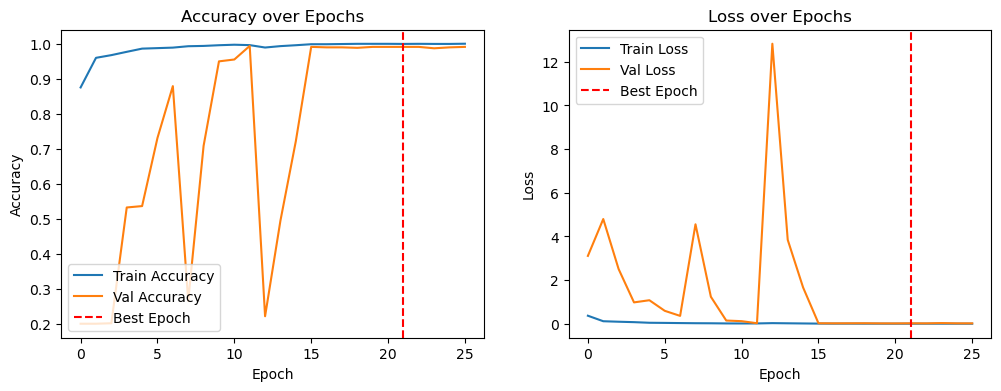

In [12]:
# Choose the best epoch
best_epoch = metrics["val_loss"].idxmin() + 1

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(metrics["accuracy"], label="Train Accuracy")
plt.plot(metrics["val_accuracy"], label="Val Accuracy")
plt.axvline(best_epoch, color="r", linestyle="--", label="Best Epoch")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(metrics["loss"], label="Train Loss")
plt.plot(metrics["val_loss"], label="Val Loss")
plt.axvline(best_epoch, color="r", linestyle="--", label="Best Epoch")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper left')

plt.show()

I then evaluated the model on the test set. It achieved a test accuracy of 99.33%, showing that the training process was very successful.

In [13]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4), # Learning rate at best epoch
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9933 - loss: 0.0243
Test Loss: 0.0243
Test Accuracy: 0.9933


### **Model Refinement**

The test accuracy was initially very high, so I performed some robustness tests to see if the model could still generalize well to noisy, blurry, and rotated images.

The model performed well with rotated images (98.53% accuracy) but declined in performance significantly for noisy (37.87% accuracy) and blurred (79.87% accuracy) images.

In [14]:
# Create a noisy test set
noise_test = X_test + np.random.normal(0, 0.05, X_test.shape)

# Clip values to ensure they stay between 0 and 1
noise_test = np.clip(noise_test, 0, 1) 

# Create a blurry test set
blur_test = np.array([GaussianBlur(img, (5,5), 0) for img in X_test])

# Create a rotated test set
rotate_test = np.rot90(X_test, k=1, axes=(1, 2))

# Evaluation
print("Evaluation on Noisy Data: ")
model.evaluate(noise_test, y_test)

print("Evaluation on Blurred Data:")
model.evaluate(blur_test, y_test)

print("Evaluation on Rotated Data")
loss, acc = model.evaluate(rotate_test, y_test)

Evaluation on Noisy Data: 
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.3787 - loss: 5.3900
Evaluation on Blurred Data:
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7987 - loss: 0.5416
Evaluation on Rotated Data
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9853 - loss: 0.0395


To generalize well to noisy and blurry images, the model needed to be retrained with noise and blur added to the training data. I wrote a function below to randomly apply noise and blur to an array of images. The function adds a random severity of noise, salt and pepper (random pixels turned black or white), brightness adjustments, and blur to the images.

In [15]:
def add_noise_with_blur(X):  
    X_noisy = X.copy()
    H, W, C = X_noisy.shape[1], X_noisy.shape[2], X_noisy.shape[3]

    for i in range(X_noisy.shape[0]):
        # Random severity per image
        severity = random.choice(["mild", "medium", "severe"])
        
        if severity == "mild":
            gauss_std = 0.05
            sp_amount = 0.01
            brightness_range = (0.95, 1.05)
            blur_ksize = 1
        elif severity == "medium":
            gauss_std = 0.1
            sp_amount = 0.03
            brightness_range = (0.8, 1.2)
            blur_ksize = 3
        elif severity == "severe":
            gauss_std = 0.2
            sp_amount = 0.07
            brightness_range = (0.5, 1.5)
            blur_ksize = 5
        
        # Gaussian noise
        X_noisy[i] += np.random.normal(0, gauss_std, (H, W, C)).astype(np.float32)
        
        # Salt-and-pepper noise
        num_pixels = H * W
        num_salt = int(sp_amount * num_pixels)
        coords_y = np.random.randint(0, H, num_salt)
        coords_x = np.random.randint(0, W, num_salt)
        vals = np.random.choice([0, 1], size=num_salt)
        X_noisy[i, coords_y, coords_x, :] = vals[:, None]  # same value for all channels
        
        # Random brightness / contrast
        brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
        X_noisy[i] *= brightness_factor
        
        # Gaussian blur
        if blur_ksize > 1:
            X_noisy[i] = GaussianBlur(X_noisy[i], (blur_ksize, blur_ksize), 0)
    
    # Clip to valid range
    X_noisy = np.clip(X_noisy, 0, 1)
    
    return X_noisy

I randomly chose half the indices from the training set to apply the function to.

In [16]:
# Number of samples
num_samples = X_train.shape[0]

# Randomly select half of the indices
half_indices = np.random.choice(num_samples, size=num_samples // 2, replace=False)

# Apply noise and blur
X_train[half_indices] = add_noise_with_blur(X_train[half_indices])

print(X_train.dtype)

float32


In [17]:
# Save printed training logs and print to console
sys.stdout = DoubleLog("updated_training_console_output.txt")

# CSV logger saves per-epoch results
csv_logger = CSVLogger("updated_training_metrics.csv", append=False)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,                       # Max number of epochs
    batch_size=32,                   # Number of samples processed at a time
    validation_data=(X_val, y_val),  # Use validation data during training
    callbacks=[early_stopping, reduce_lr, csv_logger], # Add callbacks
    verbose=2
)

# Save the trained model weights
model.save_weights("updated_model.weights.h5")

# Close the logger
sys.stdout.close()


# # GitHub URLs containing trained model data
# console_output_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/updated_training_console_output.txt"
# metrics_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/updated_training_metrics.csv"
# model_url = "https://github.com/rheanibert04/CNN_Rice_Classification/raw/refs/heads/main/updated_model.weights.h5"

# # Retrieve and print training output
# response = requests.get(console_output_url)
# console_text = response.text
# print("Training Output")
# print(console_text)

# # Load training metrics for later use
# metrics = pd.read_csv(metrics_url)

# # Download the model weights file
# local_file = "updated_model.weights.h5"
# response = requests.get(model_url)
# with open(local_file, "wb") as f:
#     f.write(response.content)

# # Build the model and load the weights
# model = build_model()
# model.load_weights(local_file)

# # Delete the local weights file
# os.remove(local_file)

Epoch 1/10
110/110 - 93s - 844ms/step - accuracy: 0.8834 - loss: 0.5539 - val_accuracy: 0.9880 - val_loss: 0.0356 - learning_rate: 1.0000e-04
Epoch 2/10
110/110 - 117s - 1s/step - accuracy: 0.9660 - loss: 0.0907 - val_accuracy: 0.9947 - val_loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 3/10
110/110 - 107s - 976ms/step - accuracy: 0.9854 - loss: 0.0520 - val_accuracy: 0.9947 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 4/10
110/110 - 106s - 960ms/step - accuracy: 0.9920 - loss: 0.0250 - val_accuracy: 0.9960 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 5/10
110/110 - 104s - 944ms/step - accuracy: 0.9946 - loss: 0.0195 - val_accuracy: 0.9947 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 6/10
110/110 - 117s - 1s/step - accuracy: 0.9963 - loss: 0.0155 - val_accuracy: 0.9960 - val_loss: 0.0054 - learning_rate: 1.0000e-04
Epoch 7/10
110/110 - 117s - 1s/step - accuracy: 0.9966 - loss: 0.0138 - val_accuracy: 0.9973 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 8/1

In [18]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4), # Learning rate at best epoch
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9947 - loss: 0.0105    
Test Loss: 0.0105
Test Accuracy: 0.9947


In [19]:
test_loss, test_acc = model.evaluate(noise_test, y_test)
print(f"New Accuracy on Noisy Data: {test_acc:.4f}")

test_loss, test_acc = model.evaluate(blur_test, y_test)
print(f"New Accuracy on blurry Data: {test_acc:.4f}")

test_loss, test_acc = model.evaluate(rotate_test, y_test)
print(f"New Accuracy on rotated Data: {test_acc:.4f}")

test_loss, test_acc = model.evaluate(add_noise_with_blur(X_test), y_test)
print(f"accuracy on data but through function: {test_acc:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8040 - loss: 1.2907
New Accuracy on Noisy Data: 0.8040
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9973 - loss: 0.0131
New Accuracy on blurry Data: 0.9973
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9907 - loss: 0.0294    
New Accuracy on rotated Data: 0.9907
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9773 - loss: 0.0612
accuracy on data but through function: 0.9773


In [20]:
import numpy as np
import cv2  # OpenCV for Gaussian blur



noise_test = add_noise_with_blur(X_test, severity="severe")
# Pick one image to visualize
idx = 0
original_img = X_test[idx]
noisy_img = noise_test[idx]

# Plot side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(noisy_img)
plt.title("Noisy Image")
plt.axis("off")

plt.show()


TypeError: add_noise_with_blur() got an unexpected keyword argument 'severity'

In [ ]:
# Get model predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()